In [78]:
import ast
import os
import pickle
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [68]:

# ======================
# 1. Configuration
# ======================

DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print(f"MPS support: {torch.backends.mps.is_available()}")

BASE_DIR = '../data/'  # Parent directory containing both folders
TRAIN_AUDIO_DIR = os.path.join(BASE_DIR, 'train_audio/')  # Individual bird recordings
TRAIN_SOUNDSCAPES_DIR = os.path.join(BASE_DIR, 'train_soundscapes/')  # Field recordings
TEST_SOUNDSCAPES_DIR = os.path.join(BASE_DIR, 'test_soundscapes/')
AUDIO_DIR = '../data/train_audio/'
SR = 32000
DURATION = 5
N_MELS = 128

MPS support: True


In [62]:
# ======================
# 2. Data Loading/Preparation
# ======================

class BirdCLEFDataset(Dataset):
    def __init__(self, df, audio_dir, label_encoder):
        self.df = df
        self.audio_dir = AUDIO_DIR
        self.all_species = sorted(df['primary_label'].unique())
        self.label_encoder = label_encoder
        self.sr = SR
        self.audio_len = SR * DURATION
        
        # Audio transforms
        self.mel_spec = MelSpectrogram(
            sample_rate=SR,
            n_fft=2048,
            win_length=1024,
            hop_length=512,
            n_mels=N_MELS,
            f_min=500,
            f_max=14000
        )
        self.to_db = AmplitudeToDB()

    def __getitem__(self, idx):

         # Pre-compute FULL file paths (critical fix)
        self.file_paths = [
            os.path.join(audio_dir, str(row['filename']))
            for _, row in df.iterrows()
        ]
        
        # Verify first 5 paths exist
        for path in self.file_paths[:5]:
            if not os.path.exists(path):
                raise FileNotFoundError(f"Training file not found: {path}")
        
        # Audio processing
        waveform, _ = torchaudio.load(self.df.iloc[idx]['filepath'])
        waveform = self._fix_length(waveform)
        
        # Spectrogram
        spec = self.to_db(self.mel_spec(waveform))
        spec = (spec - spec.mean()) / (spec.std() + 1e-6) #normalizing the spectrogram
        
        # Labels
        return spec, combined_labels, primary_label_idx

    def _fix_length(self, waveform):
        if waveform.shape[1] > self.audio_len:
            return waveform[:, :self.audio_len]
        return F.pad(waveform, (0, self.audio_len - waveform.shape[1]))


In [63]:
# ======================
# 3. Label Encoding
# ======================

# Load and preprocess labels
df = pd.read_csv("../data/train.csv")

# Parse secondary labels (safely convert string to list)
df['secondary_labels'] = df['secondary_labels'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else []
)

# Get complete species list
all_species = sorted(set(df['primary_label']).union(
    *df['secondary_labels'].apply(set)
))

# Primary label encoding
label_encoder = LabelEncoder()
df['label_idx'] = label_encoder.fit_transform(df['primary_label'])

# Efficient multi-hot encoding (vectorized)
secondary_matrix = pd.DataFrame(
    np.stack(df['secondary_labels'].apply(
        lambda x: np.isin(all_species, x).astype(np.float32)
    )),
    columns=all_species
).add_prefix("secondary_")

# Combined labels with weights
df['combined_labels'] = secondary_matrix.mul(0.3).values.tolist()  # Secondary=0.3
for idx, species in enumerate(all_species):
    primary_mask = (df['primary_label'] == species)
    df.loc[primary_mask, 'combined_labels'] = df.loc[primary_mask, 'combined_labels'].apply(
        lambda x: [1.0 if i == idx else val for i, val in enumerate(x)]
    )

df = pd.concat([df, secondary_matrix], axis=1)

In [64]:
criterion = torch.nn.BCEWithLogitsLoss()

In [65]:
print(df.columns)  # Should include 'filename' and 'primary_label'
print(df['filename'].head())  # Should show relative paths like 'acafly/XC109605.ogg'

Index(['primary_label', 'secondary_labels', 'type', 'filename', 'collection',
       'rating', 'url', 'latitude', 'longitude', 'scientific_name',
       ...
       'secondary_yebfly1', 'secondary_yebsee1', 'secondary_yecspi2',
       'secondary_yectyr1', 'secondary_yehbla2', 'secondary_yehcar1',
       'secondary_yelori1', 'secondary_yeofly1', 'secondary_yercac1',
       'secondary_ywcpar'],
      dtype='object', length=222)
0    1139490/CSA36385.ogg
1    1139490/CSA36389.ogg
2    1192948/CSA36358.ogg
3    1192948/CSA36366.ogg
4    1192948/CSA36373.ogg
Name: filename, dtype: object


In [66]:
# ======================
# Visualize Spectrogram
# ======================


# Initialize dataset
dataset = BirdCLEFDataset(df, AUDIO_DIR, all_species, label_encoder)  

# Get one example
spec, combined_labels, primary_label_idx = dataset[0]  # Now returns 3 items

# Plot
plt.figure(figsize=(10, 4))
plt.imshow(
    spec.squeeze().numpy(), 
    aspect="auto", 
    origin="lower", 
    cmap="viridis",
    extent=[0, DURATION, 0, SR//2]
)
plt.colorbar(format="%+2.0f dB")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title(f"Mel Spectrogram (Label: {dataset.label_encoder.inverse_transform([primary_label_idx])[0]})")
plt.show()


NameError: name 'audio_dir' is not defined

In [69]:


# Load metadata
df = pd.read_csv("../data/train.csv")

# Create label encoder from primary labels only
label_encoder = LabelEncoder()
df['label_idx'] = label_encoder.fit_transform(df['primary_label'])

Total species: 206
Sample species: ['1139490' '1192948' '1194042' '126247' '1346504']


In [72]:
class BirdCLEFDataset(Dataset):
    def __init__(self, df, audio_dir, label_encoder, sr=32000, duration=5, n_mels=128):
        self.df = df
        self.audio_dir = audio_dir
        self.label_encoder = label_encoder
        self.sr = sr
        self.audio_len = sr * duration
        
        # Pre-compute file paths (handles nested dirs)
        self.file_paths = [
            os.path.join(audio_dir, row['filename'])
            for _, row in df.iterrows()
        ]
        
        # Audio transforms
        self.mel_spec = MelSpectrogram(
            sample_rate=sr,
            n_fft=2048,
            win_length=1024,
            hop_length=512,
            n_mels=n_mels,
            f_min=500,
            f_max=14000
        )
        self.to_db = AmplitudeToDB()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Load audio
        waveform, _ = torchaudio.load(self.file_paths[idx])
        waveform = self._fix_length(waveform)
        
        # Create spectrogram
        spec = self.to_db(self.mel_spec(waveform))
        spec = (spec - spec.mean()) / (spec.std() + 1e-6)  # Standardize
        
        return (
            spec,  # (1, n_mels, time_steps)
            torch.tensor(self.df.iloc[idx]['label_idx'], dtype=torch.long)  # Class index
        )

    def _fix_length(self, waveform):
        if waveform.shape[1] > self.audio_len:
            return waveform[:, :self.audio_len]
        return torch.nn.functional.pad(waveform, (0, self.audio_len - waveform.shape[1]))

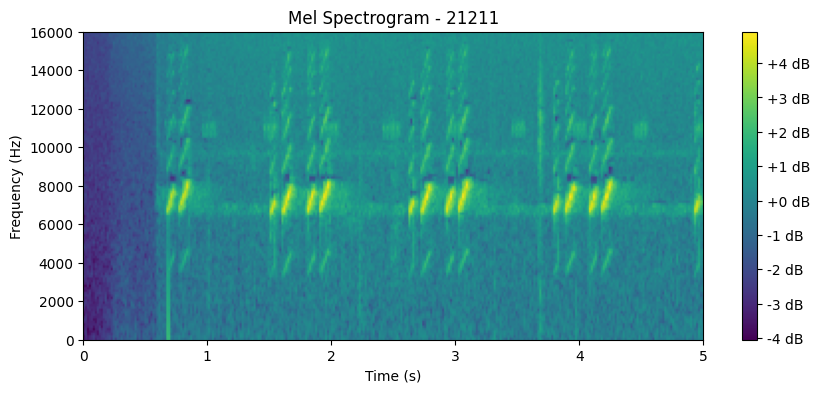

In [77]:
def plot_spectrogram(dataset, index):
    spec, label_idx = dataset[index]
    
    # Convert to numpy
    spec_np = spec.squeeze().numpy()  # Remove channel dim
    label = label_encoder.inverse_transform([label_idx.numpy()])[0]
    
    # Plot
    plt.figure(figsize=(10, 4))
    plt.imshow(
        spec_np, 
        aspect='auto', 
        origin='lower',
        cmap='viridis',
        extent=[0, DURATION, 0, SR//2]  # Time (s), Freq (Hz)
    )
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'Mel Spectrogram - {label}')
    plt.show()

# Usage example
dataset = BirdCLEFDataset(df, "../data/train_audio", label_encoder)
plot_spectrogram(dataset, 54)